In [1]:
import numpy as np
import torch
from transformers import *
from sklearn.cluster import KMeans
import time
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

You are using torchaudio==0.9.0, but torchaudio>=0.10.0 is required to use MCTCTFeatureExtractor. This requires torch>=1.10.0. Please upgrade torch and torchaudio.
You are using torch==1.9.0+cu111, but torch>=1.10.0 is required to use ViltModel. Please upgrade torch.


cuda


In [2]:

train_embeddings = {}
test_embeddings = {}
train_embeddings['sents'] = np.load('train/sents.npy')
train_embeddings['vectors'] = np.load('train/vectors.npy')
train_embeddings['labels'] = np.load('train/labels.npy')
test_embeddings['sents'] = np.load('test/sents.npy')
test_embeddings['vectors'] = np.load('test/vectors.npy')
test_embeddings['labels'] = np.load('test/labels.npy')

In [3]:
LABELS = ['it', 'koran', 'law', 'medical', 'subtitles']
N_CLUSTERS = 5
def kmeans(train_data, num_clusters=5):
    model = KMeans(n_clusters=num_clusters,
                   max_iter=250,
                   random_state=1,
                   verbose=1)
    
    model.fit(train_data)
    return model


def get_predictions(model, test_data):
    return model.predict(test_data)


def assign_labels_to_clusters(true_labels, predictions, num_clusters=5):
    cluster_assignment = {}
    true_count = 0
    total = 0
    for k in range(num_clusters):
        count = [0] * 5
        for i, pred in enumerate(predictions):
            if pred == k:
                count[LABELS.index(true_labels[i])] += 1
        max_count = max(count)
        total_count = sum(count)
        cluster_assignment[k] = (LABELS[count.index(max_count)], max_count, total_count)
        true_count += max_count
        total += total_count
    acc = true_count / total
    return cluster_assignment, acc


def calc_test_accuracy(true_labels, predictions, cluster_assignment):
    total = 0
    true_count = 0
    for i, pred in enumerate(predictions):
        if cluster_assignment[pred][0] == true_labels[i]:
            true_count +=1
        total += 1
    return true_count / total

In [4]:
start = time.time()
model = kmeans(train_embeddings['vectors'], N_CLUSTERS)
end  = time.time()
print(f"Time taken to converge: {(end-start) / 3600} hrs.")

Initialization complete
Iteration 0, inertia 22790926.0
Iteration 1, inertia 13786034.0
Iteration 2, inertia 13487329.0
Iteration 3, inertia 13452438.0
Iteration 4, inertia 13439865.0
Iteration 5, inertia 13434052.0
Iteration 6, inertia 13430929.0
Iteration 7, inertia 13429064.0
Iteration 8, inertia 13427931.0
Iteration 9, inertia 13427163.0
Iteration 10, inertia 13426635.0
Iteration 11, inertia 13426200.0
Iteration 12, inertia 13425828.0
Iteration 13, inertia 13425499.0
Iteration 14, inertia 13425167.0
Iteration 15, inertia 13424807.0
Iteration 16, inertia 13424444.0
Iteration 17, inertia 13424035.0
Iteration 18, inertia 13423565.0
Iteration 19, inertia 13423014.0
Iteration 20, inertia 13422293.0
Iteration 21, inertia 13421278.0
Iteration 22, inertia 13419755.0
Iteration 23, inertia 13416882.0
Iteration 24, inertia 13409056.0
Iteration 25, inertia 13368092.0
Iteration 26, inertia 13040422.0
Iteration 27, inertia 12585721.0
Iteration 28, inertia 12510224.0
Iteration 29, inertia 1249423

Initialization complete
Iteration 0, inertia 22348220.0
Iteration 1, inertia 13278119.0
Iteration 2, inertia 12812083.0
Iteration 3, inertia 12547040.0
Iteration 4, inertia 12498453.0
Iteration 5, inertia 12490220.0
Iteration 6, inertia 12488256.0
Iteration 7, inertia 12487461.0
Iteration 8, inertia 12487000.0
Iteration 9, inertia 12486651.0
Iteration 10, inertia 12486398.0
Iteration 11, inertia 12486235.0
Iteration 12, inertia 12486124.0
Iteration 13, inertia 12486050.0
Iteration 14, inertia 12486006.0
Iteration 15, inertia 12485978.0
Iteration 16, inertia 12485951.0
Iteration 17, inertia 12485946.0
Iteration 18, inertia 12485935.0
Iteration 19, inertia 12485919.0
Iteration 20, inertia 12485909.0
Iteration 21, inertia 12485901.0
Iteration 22, inertia 12485898.0
Iteration 23, inertia 12485892.0
Iteration 24, inertia 12485888.0
Iteration 25, inertia 12485878.0
Iteration 26, inertia 12485879.0
Iteration 27, inertia 12485878.0
Iteration 28, inertia 12485885.0
Iteration 29, inertia 1248587

In [5]:
train_pred = get_predictions(model, train_embeddings['vectors'])
cluster_assignment, accuracy = assign_labels_to_clusters(train_embeddings['labels'], train_pred, N_CLUSTERS)
print(f"Train accuracy is {accuracy:.4f}")

test_pred = get_predictions(model, test_embeddings['vectors'])
test_accuracy = calc_test_accuracy(test_embeddings['labels'], test_pred, cluster_assignment)
print(f"Test accuracy is {test_accuracy:.4f}")

np.save('test_pred_kmeans_k10_distilBERT.npy', test_pred)

Train accuracy is 0.8360
Test accuracy is 0.6884


In [7]:
for k in range(N_CLUSTERS):
    print(f'Cluster-{k+1} | label: {cluster_assignment[k][0]} | Purity: {cluster_assignment[k][1]/cluster_assignment[k][2]}')

Cluster-1 | label: law | Purity: 0.9295197933233066
Cluster-2 | label: it | Purity: 0.8301599774339136
Cluster-3 | label: subtitles | Purity: 0.8178549854258182
Cluster-4 | label: medical | Purity: 0.944399670299478
Cluster-5 | label: it | Purity: 0.6248450929442334


In [8]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

tsne = TSNE(n_components=2, verbose=1, random_state=1)
z = tsne.fit_transform(test_embeddings['vectors'])

/opt/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.008s...
[t-SNE] Computed neighbors for 10000 samples in 3.204s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.272582
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.066017
[t-SNE] KL divergence after 1000 iterations: 2.215315


<AxesSubplot:xlabel='comp-1', ylabel='comp-2'>

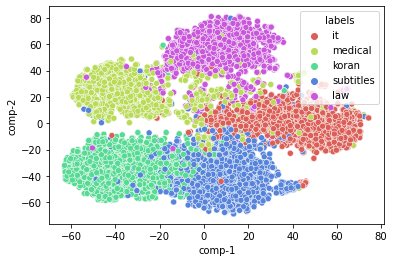

In [13]:
df = pd.DataFrame()
df["labels"] = test_embeddings['labels']
df["clusters"] = [cluster_assignment[pred][0] for pred in test_pred]
# df["clusters"] = test_pred
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]
sns.scatterplot(data=df, x="comp-1", y="comp-2", hue="labels", palette=sns.color_palette("hls", 5))

/opt/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='comp-1', ylabel='comp-2'>

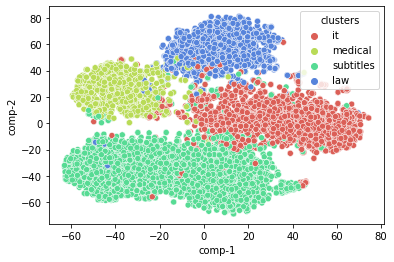

In [14]:
sns.scatterplot(data=df, x="comp-1", y="comp-2", hue="clusters", palette=sns.color_palette("hls", 5))